In [4]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  3789k      0  0:00:21  0:00:21 --:--:-- 5773k


In [5]:
import os, pathlib, shutil, random
from tensorflow import keras
batch_size = 32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    # Check if the directory already exists before creating it
    if not os.path.exists(val_dir / category):
        os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
text_only_train_ds = train_ds.map(lambda x, y: x)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [6]:
from tensorflow.keras import layers

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [7]:
!pip install tensorflow==2.19


In [8]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Embedding, LSTM, Dropout

from sklearn.model_selection import train_test_split
from google.colab import files
import re, os


In [9]:
# Correct imports (no mixing keras and tensorflow.keras)
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
import numpy as np

# -----------------------------
# Assignment Parameters
# -----------------------------
VOCAB_SIZE = 10000          # Top 10,000 words
MAX_REVIEW_LENGTH = 150     # Cutoff reviews after 150 words
TRAIN_SAMPLES = 100         # Restrict training samples to 100
VAL_SAMPLES = 10000         # Validate on 10,000 samples

# -----------------------------
# Load IMDB Dataset
# -----------------------------
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=VOCAB_SIZE)

# -----------------------------
# Pad sequences
# -----------------------------
x_train = pad_sequences(x_train, maxlen=MAX_REVIEW_LENGTH)
x_test  = pad_sequences(x_test,  maxlen=MAX_REVIEW_LENGTH)

# -----------------------------
# Create small training set (100 samples)
# -----------------------------
x_small_train = x_train[:TRAIN_SAMPLES]
y_small_train = y_train[:TRAIN_SAMPLES]

# -----------------------------
# Create validation set (10,000 samples)
# -----------------------------
x_val = x_train[TRAIN_SAMPLES:TRAIN_SAMPLES + VAL_SAMPLES]
y_val = y_train[TRAIN_SAMPLES:TRAIN_SAMPLES + VAL_SAMPLES]

# -----------------------------
# Final test set (use entire x_test/y_test)
# -----------------------------
x_final_test = x_test
y_final_test = y_test

# -----------------------------
# Build a simple model
# -----------------------------
model = Sequential([
    Embedding(VOCAB_SIZE, 32, input_length=MAX_REVIEW_LENGTH),
    Flatten(),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

# -----------------------------
# Train the model
# -----------------------------
history = model.fit(
    x_small_train,
    y_small_train,
    epochs=5,
    batch_size=32,
    validation_data=(x_val, y_val)
)

# -----------------------------
# Evaluate on test set
# -----------------------------
test_loss, test_acc = model.evaluate(x_final_test, y_final_test)
print("Test accuracy:", test_acc)


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.3683 - loss: 0.6982 - val_accuracy: 0.5055 - val_loss: 0.6931
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.9845 - loss: 0.6244 - val_accuracy: 0.5051 - val_loss: 0.6929
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.9684 - loss: 0.5587 - val_accuracy: 0.4919 - val_loss: 0.6974
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 1.0000 - loss: 0.4911 - val_accuracy: 0.4943 - val_loss: 0.6973
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 1.0000 - loss: 0.4066 - val_accuracy: 0.5082 - val_loss: 0.6951
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5168 - loss: 0.6934
Test accuracy: 0.513759970664978


In [10]:
x_small_train.shape


(100, 150)

In [11]:
x_val.shape


(10000, 150)

In [12]:
x_final_test.shape


(25000, 150)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

# Constants
VOCAB_SIZE = 10000
MAX_REVIEW_LENGTH = 150

# Define model
sentiment_classifier = Sequential()
sentiment_classifier.add(Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=8,
    input_length=MAX_REVIEW_LENGTH
))
sentiment_classifier.add(Flatten())
sentiment_classifier.add(Dense(1, activation='sigmoid'))

# Compile
sentiment_classifier.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# IMPORTANT
# Build model manually so summary works
sentiment_classifier.build(input_shape=(None, MAX_REVIEW_LENGTH))

# Summary
sentiment_classifier.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 150, 8)         │        80,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,201 (317.19 KB)

 Trainable params: 81,201 (317.19 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

# --- FIX 1: Use .keras format instead of .h5 (Keras 3 requirement) ---
checkpoint_callback = ModelCheckpoint(
    filepath="sentiment_classifier.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)

# --- FIX 2: Fit model ---
train_history = sentiment_classifier.fit(
    x_small_train,
    y_small_train,
    epochs=30,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint_callback],
    verbose=1
)


Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4588 - loss: 0.6954 - val_accuracy: 0.4972 - val_loss: 0.6937
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.7917 - loss: 0.6708 - val_accuracy: 0.4996 - val_loss: 0.6934
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.9253 - loss: 0.6530 - val_accuracy: 0.4991 - val_loss: 0.6934
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.9691 - loss: 0.6393 - val_accuracy: 0.5001 - val_loss: 0.6934
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.9939 - loss: 0.6248 - val_accuracy: 0.4991 - val_loss: 0.6935
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.9939 - loss: 0.6103 - val_accuracy: 0.4972 - val_loss: 0.6937
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 1.0000 - loss: 0.5969 - val_accuracy: 0.5017 - val_loss: 0.6935
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 1.0000 - loss: 0.5825 - val_accuracy: 0.5058 - val_loss: 0.

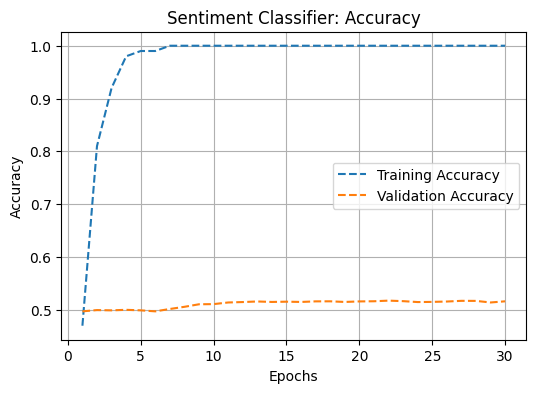

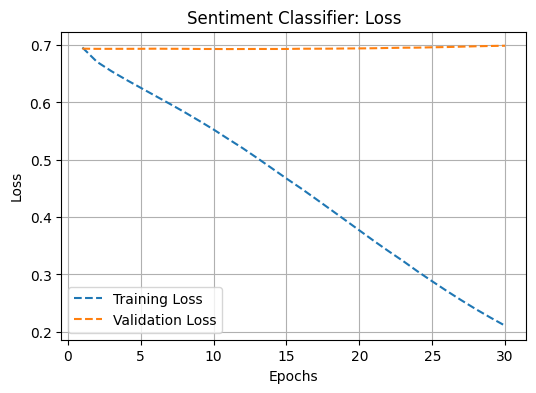

In [17]:
import matplotlib.pyplot as plt

# Extract training history
train_accuracy = train_history.history['accuracy']
val_accuracy = train_history.history['val_accuracy']

train_loss = train_history.history["loss"]
val_loss = train_history.history["val_loss"]

epoch_range = range(1, len(train_accuracy) + 1)

# ---- Accuracy Plot ----
plt.figure(figsize=(6, 4))
plt.plot(epoch_range, train_accuracy, linestyle="dashed", label="Training Accuracy")
plt.plot(epoch_range, val_accuracy, linestyle="dashed", label="Validation Accuracy")
plt.title("Sentiment Classifier: Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# ---- Loss Plot ----
plt.figure(figsize=(6, 4))
plt.plot(epoch_range, train_loss, linestyle="dashed", label="Training Loss")
plt.plot(epoch_range, val_loss, linestyle="dashed", label="Validation Loss")
plt.title("Sentiment Classifier: Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.show()


In [18]:
import os

print(os.listdir())


['.config', 'aclImdb_v1.tar.gz', 'aclImdb', 'sentiment_classifier.keras', 'sample_data']


In [19]:
from tensorflow.keras.models import load_model

loaded_model = load_model("sentiment_classifier.keras")

test_loss, test_accuracy = loaded_model.evaluate(
    x_final_test,
    y_final_test,
    verbose=1
)

print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")


782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5121 - loss: 0.6928
Test Loss: 0.693
Test Accuracy: 0.510


**Model 2: Baseline Model with Embedded Layer (Training Sample Size: 10,000)**

In [20]:
# ===============================
# Model 2: IMDB Data Preprocessing
# ===============================

# 1️⃣ Imports
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# 2️⃣ Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# 3️⃣ Constants for data configuration
MAX_VOCAB_SIZE = 10000          # Consider only top 10,000 words
MAX_SEQUENCE_LENGTH = 150       # Truncate/pad reviews to 150 words

# 4️⃣ Load IMDB dataset (top 10k words)
(train_reviews, train_sentiments), (test_reviews, test_sentiments) = imdb.load_data(num_words=MAX_VOCAB_SIZE)

# 5️⃣ Pad sequences to uniform length
padded_train_reviews = pad_sequences(train_reviews, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
padded_test_reviews = pad_sequences(test_reviews, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# 6️⃣ Combine all data for stratified splitting (training + validation)
all_reviews = np.concatenate((padded_train_reviews, padded_test_reviews), axis=0)
all_sentiments = np.concatenate((train_sentiments, test_sentiments), axis=0)

# 7️⃣ Split 10,000 training samples and 10,000 validation samples
train_reviews_final, val_reviews, train_sentiments_final, val_sentiments = train_test_split(
    all_reviews,
    all_sentiments,
    train_size=10000,
    test_size=10000,
    random_state=42,
    stratify=all_sentiments
)

# 8️⃣ Extract 6,000 test samples from the original test set
_, test_reviews_final, _, test_sentiments_final = train_test_split(
    padded_test_reviews,
    test_sentiments,
    test_size=6000,
    random_state=42,
    stratify=test_sentiments
)

In [21]:
train_reviews_final.shape


(10000, 150)

In [22]:
val_reviews.shape


(10000, 150)

In [23]:
test_reviews_final.shape


(6000, 150)

In [25]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
import numpy as np

MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 150
EMBEDDING_DIM = 8

(train_reviews, train_sentiments), (test_reviews, test_sentiments) = imdb.load_data(num_words=MAX_VOCAB_SIZE)

padded_train_reviews = pad_sequences(train_reviews, maxlen=MAX_SEQUENCE_LENGTH)
padded_test_reviews = pad_sequences(test_reviews, maxlen=MAX_SEQUENCE_LENGTH)

all_reviews = np.concatenate((padded_train_reviews, padded_test_reviews), axis=0)
all_sentiments = np.concatenate((train_sentiments, test_sentiments), axis=0)

train_reviews_final, val_reviews, train_sentiments_final, val_sentiments = train_test_split(
    all_reviews, all_sentiments,
    train_size=10000,
    test_size=10000,
    random_state=42,
    stratify=all_sentiments
)

_, test_reviews_final, _, test_sentiments_final = train_test_split(
    padded_test_reviews, test_sentiments,
    test_size=6000,
    random_state=42,
    stratify=test_sentiments
)

sentiment_analysis_model = Sequential()
sentiment_analysis_model.add(Embedding(
    input_dim=MAX_VOCAB_SIZE,
    output_dim=EMBEDDING_DIM,
    input_shape=(MAX_SEQUENCE_LENGTH,)  # use input_shape instead of deprecated input_length
))
sentiment_analysis_model.add(Flatten())
sentiment_analysis_model.add(Dense(units=1, activation='sigmoid'))

sentiment_analysis_model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

sentiment_analysis_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 150, 8)         │        80,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,201 (317.19 KB)

 Trainable params: 81,201 (317.19 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint(
    filepath="best_sentiment_model.h5",
    save_best_only=True,
    monitor="val_loss"
)

train_history1 = sentiment_analysis_model.fit(
    train_reviews_final, train_sentiments_final,
    epochs=30,
    batch_size=32,
    validation_data=(val_reviews, val_sentiments),
    callbacks=[model_checkpoint]
)


Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5470 - loss: 0.6879

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.5472 - loss: 0.6879 - val_accuracy: 0.7274 - val_loss: 0.6170
Epoch 2/30
299/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7883 - loss: 0.5485

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7893 - loss: 0.5460 - val_accuracy: 0.8228 - val_loss: 0.4286
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8524 - loss: 0.3683

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8524 - loss: 0.3682 - val_accuracy: 0.8434 - val_loss: 0.3626
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8883 - loss: 0.2876

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8883 - loss: 0.2876 - val_accuracy: 0.8530 - val_loss: 0.3387
Epoch 5/30
286/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9123 - loss: 0.2389

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9125 - loss: 0.2382 - val_accuracy: 0.8574 - val_loss: 0.3293
Epoch 6/30
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9286 - loss: 0.2013

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9286 - loss: 0.2013 - val_accuracy: 0.8597 - val_loss: 0.3267
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9411 - loss: 0.1710 - val_accuracy: 0.8596 - val_loss: 0.3284
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9518 - loss: 0.1450 - val_accuracy: 0.8582 - val_loss: 0.3333
Epoch 9/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9642 - loss: 0.1221 - val_accuracy: 0.8555 - val_loss: 0.3408
Epoch 10/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9733 - loss: 0.1020 - val_accuracy: 0.8547 - val_loss: 0.3504
Epoch 11/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9790 - loss: 0.0844 - val_accuracy: 0.8523 - val_loss: 0.3617
Epoch 12/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9835 - loss: 0.0691 - val_accuracy: 0.8517 - val_loss: 0.3743
Epoch 13/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9873 - loss: 0.0560 - val_accuracy: 0.8501 - 

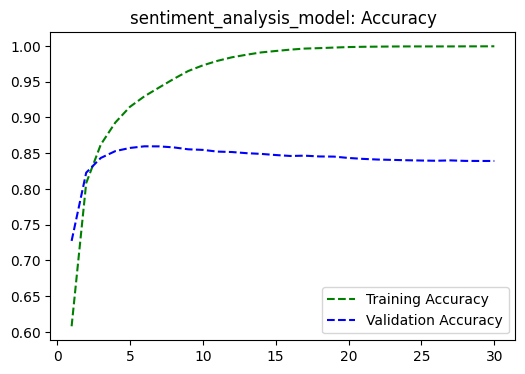

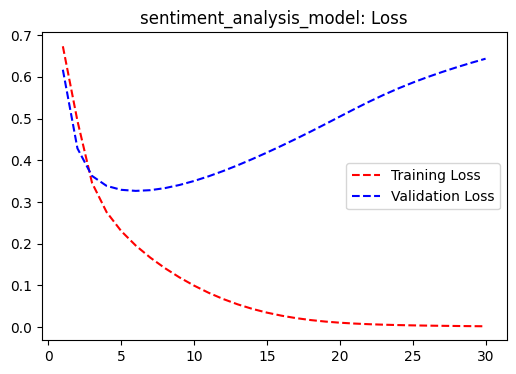

In [27]:
import matplotlib.pyplot as plt

train_accuracy = train_history1.history['accuracy']
val_accuracy = train_history1.history['val_accuracy']

train_loss = train_history1.history['loss']
val_loss = train_history1.history['val_loss']

epochs_range = range(1, len(train_accuracy) + 1)

# Accuracy plot
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, train_accuracy, color="green", linestyle="dashed", label="Training Accuracy")
plt.plot(epochs_range, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("sentiment_analysis_model: Accuracy")
plt.legend()
plt.show()

# Loss plot
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, train_loss, color="red", linestyle="dashed", label="Training Loss")
plt.plot(epochs_range, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("sentiment_analysis_model: Loss")
plt.legend()
plt.show()


In [32]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import RMSprop

# Load the model without compiling to avoid the warning
loaded_model = load_model('best_sentiment_model.h5', compile=False)

# Manually compile the model
loaded_model.compile(
    optimizer=RMSprop(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Evaluate on the test set
evaluation_results = loaded_model.evaluate(test_reviews_final, test_sentiments_final, verbose=1)

print(f'Loss: {evaluation_results[0]:.3f}')
print(f'Accuracy: {evaluation_results[1]:.3f}')


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8812 - loss: 0.2764
Loss: 0.287
Accuracy: 0.877


### **Model 3: Baseline Model with Embedded Layer (Training Sample Size: 16,000)**

In [33]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

# Constants
VOCABULARY_SIZE = 10000
MAX_SEQUENCE_LENGTH = 150

# Load IMDB dataset
(train_reviews_raw, train_labels_raw), (test_reviews_raw, test_labels_raw) = imdb.load_data(num_words=VOCABULARY_SIZE)

# Pad sequences to ensure equal length
padded_train_reviews = pad_sequences(train_reviews_raw, maxlen=MAX_SEQUENCE_LENGTH)
padded_test_reviews = pad_sequences(test_reviews_raw, maxlen=MAX_SEQUENCE_LENGTH)

# Combine all data for stratified train/validation split
all_reviews = np.concatenate((padded_train_reviews, padded_test_reviews), axis=0)
all_labels = np.concatenate((train_labels_raw, test_labels_raw), axis=0)

# Create 16,000 training samples and 10,000 validation samples
train_reviews_final, val_reviews, train_labels_final, val_labels = train_test_split(
    all_reviews,
    all_labels,
    train_size=16000,
    test_size=10000,
    random_state=42,
    stratify=all_labels
)

# Create final test set of 6,000 samples from original test set
_, test_reviews_final, _, test_labels_final = train_test_split(
    padded_test_reviews,
    test_labels_raw,
    test_size=6000,
    random_state=42,
    stratify=test_labels_raw
)


In [36]:
print("Training reviews shape:", train_reviews_final.shape)
print("Validation reviews shape:", val_reviews.shape)
print("Test reviews shape:", test_reviews_final.shape)


Training reviews shape: (16000, 150)
Validation reviews shape: (10000, 150)
Test reviews shape: (6000, 150)


### **Building model**



In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

# Define the model architecture
sentiment_analysis_model = Sequential()
sentiment_analysis_model.add(Embedding(
    input_dim=VOCABULARY_SIZE,
    output_dim=8,
    input_length=MAX_SEQUENCE_LENGTH,
    name='word_embedding_layer'
))
sentiment_analysis_model.add(Flatten(name='flatten_layer'))
sentiment_analysis_model.add(Dense(
    units=1,
    activation='sigmoid',
    name='output_layer'
))

# Build the model by specifying input shape
sentiment_analysis_model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))

# Compile the model
sentiment_analysis_model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model summary
sentiment_analysis_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ word_embedding_layer            │ (None, 150, 8)         │        80,000 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │         1,201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,201 (317.19 KB)

 Trainable params: 81,201 (317.19 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define model checkpoint callback to save the best model
best_model_checkpoint = ModelCheckpoint(
    filepath="best_sentiment_model.h5",
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)

# Train the model with checkpointing
model_training_history = sentiment_analysis_model.fit(
    x=train_reviews_final,   # Correct training data variable
    y=train_labels_final,    # Correct training labels variable
    epochs=30,
    batch_size=32,
    validation_data=(val_reviews, val_labels),  # Validation set
    callbacks=[best_model_checkpoint]
)


Epoch 1/30
489/500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5789 - loss: 0.6788

500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5808 - loss: 0.6778 - val_accuracy: 0.7765 - val_loss: 0.5058
Epoch 2/30
476/500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8207 - loss: 0.4324

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8215 - loss: 0.4303 - val_accuracy: 0.8487 - val_loss: 0.3514
Epoch 3/30
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8757 - loss: 0.3059

500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8758 - loss: 0.3059 - val_accuracy: 0.8627 - val_loss: 0.3156
Epoch 4/30
481/500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8945 - loss: 0.2562

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8947 - loss: 0.2559 - val_accuracy: 0.8672 - val_loss: 0.3040
Epoch 5/30
483/500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9117 - loss: 0.2233

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9118 - loss: 0.2231 - val_accuracy: 0.8702 - val_loss: 0.3009
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9227 - loss: 0.1966 - val_accuracy: 0.8713 - val_loss: 0.3022
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9357 - loss: 0.1731 - val_accuracy: 0.8703 - val_loss: 0.3062
Epoch 8/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9462 - loss: 0.1512 - val_accuracy: 0.8682 - val_loss: 0.3123
Epoch 9/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9565 - loss: 0.1308 - val_accuracy: 0.8680 - val_loss: 0.3204
Epoch 10/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9649 - loss: 0.1118 - val_accuracy: 0.8661 - val_loss: 0.3302
Epoch 11/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9721 - loss: 0.0945 - val_accuracy: 0.8655 - val_loss: 0.3419
Epoch 12/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9779 - loss: 0.0789 - val_accuracy: 0.8655 - v

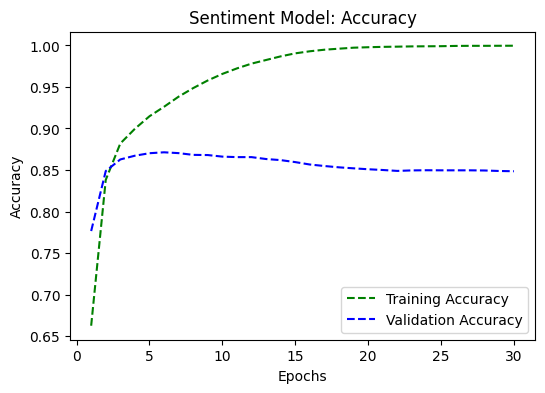

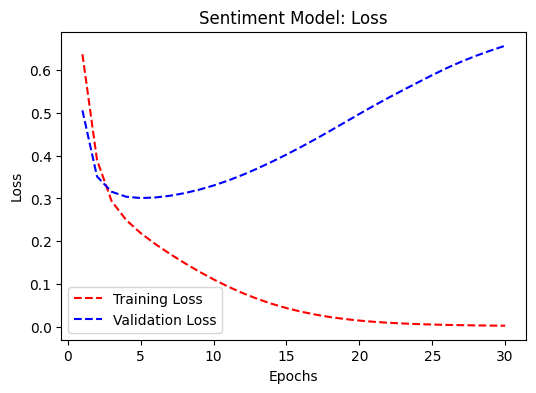

In [53]:
import matplotlib.pyplot as plt

# Extract metrics from training history
training_accuracy = model_training_history.history['accuracy']
validation_accuracy = model_training_history.history['val_accuracy']
training_loss = model_training_history.history['loss']
validation_loss = model_training_history.history['val_loss']

# Epoch range
epochs_range = range(1, len(training_accuracy) + 1)

# Plot Accuracy
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, training_accuracy, color="green", linestyle="dashed", label="Training Accuracy")
plt.plot(epochs_range, validation_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Sentiment Model: Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, training_loss, color="red", linestyle="dashed", label="Training Loss")
plt.plot(epochs_range, validation_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Sentiment Model: Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [56]:
import numpy as np
from tensorflow.keras.models import load_model

# Make sure your test data are NumPy arrays with proper dtype
test_reviews_final = np.array(test_reviews_final, dtype=np.int32)
test_labels_final = np.array(test_labels_final, dtype=np.float32)

# Load the saved model with compile=True to avoid warnings
trained_sentiment_model = load_model('best_sentiment_model.h5', compile=True)

# Evaluate the model on the test set
test_loss, test_accuracy = trained_sentiment_model.evaluate(test_reviews_final, test_labels_final, verbose=1)

print(f'Test Loss: {test_loss:.3f}')
print(f'Test Accuracy: {test_accuracy:.3f}')


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8877 - loss: 0.2560
Test Loss: 0.262
Test Accuracy: 0.886


**Model 4: LSTM-Based Sequence Model Using One-Hot Encoded Vector Sequences**



In [57]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np

# Constants
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 150

# Load IMDB dataset
(raw_train_reviews, raw_train_labels), (raw_test_reviews, raw_test_labels) = imdb.load_data(num_words=VOCAB_SIZE)

# Pad sequences
padded_train_reviews = pad_sequences(raw_train_reviews, maxlen=MAX_SEQUENCE_LENGTH)
padded_test_reviews = pad_sequences(raw_test_reviews, maxlen=MAX_SEQUENCE_LENGTH)

# Combine all data for custom train/validation split
all_reviews = np.concatenate((padded_train_reviews, padded_test_reviews), axis=0)
all_labels = np.concatenate((raw_train_labels, raw_test_labels), axis=0)

# Create 10,000 training and 10,000 validation samples
train_reviews, val_reviews, train_labels, val_labels = train_test_split(
    all_reviews,
    all_labels,
    train_size=10000,
    test_size=10000,
    random_state=42,
    stratify=all_labels
)

# Create final test set of 6,000 samples from original test set
_, final_test_reviews, _, final_test_labels = train_test_split(
    padded_test_reviews,
    raw_test_labels,
    test_size=6000,
    random_state=42,
    stratify=raw_test_labels
)

# Build Bidirectional LSTM model using Embedding
text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32", name="text_input")
x = Embedding(input_dim=VOCAB_SIZE, output_dim=32, name="embedding_layer")(text_input)
x = Bidirectional(LSTM(32, name="lstm_layer"), name="bidirectional_lstm")(x)
x = Dropout(0.5, name="dropout_layer")(x)
output = Dense(1, activation="sigmoid", name="output_layer")(x)

sentiment_analysis_model = Model(inputs=text_input, outputs=output)

# Compile model
sentiment_analysis_model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Show model architecture
sentiment_analysis_model.summary()


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer (Embedding)     │ (None, 150, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm              │ (None, 64)             │        16,640 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 336,705 (1.28 MB)

 Trainable params: 336,705 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint

# Ensure all inputs are proper NumPy arrays
train_reviews = np.array(train_reviews, dtype=np.int32)
val_reviews = np.array(val_reviews, dtype=np.int32)
train_labels = np.array(train_labels, dtype=np.float32)
val_labels = np.array(val_labels, dtype=np.float32)

# Model checkpoint configuration
model_checkpoint_callback = ModelCheckpoint(
    filepath="best_bidirectional_model.h5",
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)

# Train the model with checkpointing
bidirectional_training_history = sentiment_analysis_model.fit(
    x=train_reviews,
    y=train_labels,
    epochs=10,
    batch_size=32,
    validation_data=(val_reviews, val_labels),
    callbacks=[model_checkpoint_callback]
)


Epoch 1/10
309/313 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5854 - loss: 0.6588

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.5868 - loss: 0.6577 - val_accuracy: 0.7804 - val_loss: 0.4631
Epoch 2/10
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8264 - loss: 0.4082

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8266 - loss: 0.4077 - val_accuracy: 0.8445 - val_loss: 0.4037
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8809 - loss: 0.3037 - val_accuracy: 0.8452 - val_loss: 0.4399
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9095 - loss: 0.2513 - val_accuracy: 0.8494 - val_loss: 0.4202
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9314 - loss: 0.2059 - val_accuracy: 0.8506 - val_loss: 0.4245
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9379 - loss: 0.1839 - val_accuracy: 0.8477 - val_loss: 0.4492
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9464 - loss: 0.1588 - val_accuracy: 0.8506 - val_loss: 0.4238
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9566 - loss: 0.1348 - val_accuracy: 0.8456 - val_loss: 0.4567
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9570 - loss: 0.1318 - val_accuracy: 0.842

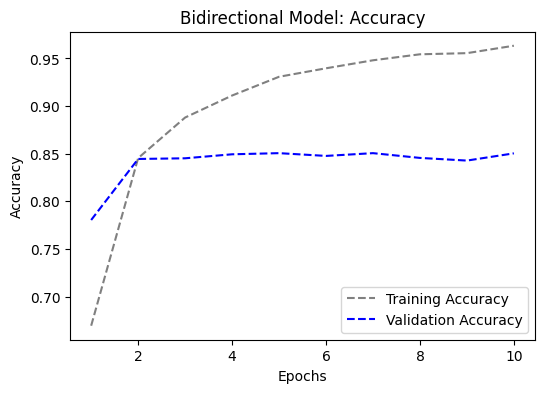

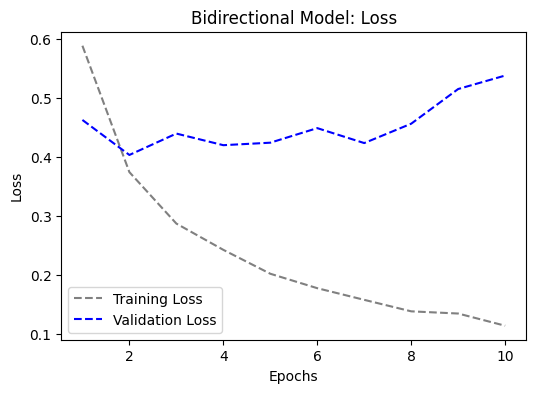

In [59]:
import matplotlib.pyplot as plt

# Extract training metrics
train_accuracy = bidirectional_training_history.history['accuracy']
val_accuracy = bidirectional_training_history.history['val_accuracy']
train_loss = bidirectional_training_history.history['loss']
val_loss = bidirectional_training_history.history['val_loss']

# Create epoch range
epochs_range = range(1, len(train_accuracy) + 1)

# Plot Accuracy
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, train_accuracy, color="grey", linestyle="dashed", label="Training Accuracy")
plt.plot(epochs_range, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Bidirectional Model: Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plot Loss
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, train_loss, color="grey", linestyle="dashed", label="Training Loss")
plt.plot(epochs_range, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Bidirectional Model: Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [60]:
# Load the trained bidirectional model
trained_bidirectional_model = load_model('best_bidirectional_model.h5', compile=False)

# Recompile the model to avoid warning
trained_bidirectional_model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Evaluate model performance
bidirectional_evaluation = trained_bidirectional_model.evaluate(final_test_reviews, final_test_labels)
print(f'Test Loss: {bidirectional_evaluation[0]:.3f}')
print(f'Test Accuracy: {bidirectional_evaluation[1]:.3f}')

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8570 - loss: 0.3724
Test Loss: 0.368
Test Accuracy: 0.857


### **Model 5: LSTM Model with Embedding Layer (Training Sample Size: 16,000)**



In [61]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Input, Model
from sklearn.model_selection import train_test_split
import numpy as np

# Constants
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 150

# Load IMDB data with top 10,000 words
(raw_train_reviews, raw_train_labels), (raw_test_reviews, raw_test_labels) = imdb.load_data(num_words=VOCAB_SIZE)

# Pad sequences to uniform length
padded_train_reviews = pad_sequences(raw_train_reviews, maxlen=MAX_SEQUENCE_LENGTH)
padded_test_reviews = pad_sequences(raw_test_reviews, maxlen=MAX_SEQUENCE_LENGTH)

# Combine all for custom split
all_reviews = np.concatenate((padded_train_reviews, padded_test_reviews), axis=0)
all_labels = np.concatenate((raw_train_labels, raw_test_labels), axis=0)

# 16,000 training, 10,000 validation
train_reviews, val_reviews, train_labels, val_labels = train_test_split(
    all_reviews,
    all_labels,
    train_size=16000,
    test_size=10000,
    random_state=42,
    stratify=all_labels
)

# 6,000 test samples from original test set
_, final_test_reviews, _, final_test_labels = train_test_split(
    padded_test_reviews,
    raw_test_labels,
    test_size=6000,
    random_state=42,
    stratify=raw_test_labels
)

# Ensure NumPy arrays have correct dtype
train_reviews = np.array(train_reviews, dtype=np.int32)
val_reviews = np.array(val_reviews, dtype=np.int32)
final_test_reviews = np.array(final_test_reviews, dtype=np.int32)

train_labels = np.array(train_labels, dtype=np.float32)
val_labels = np.array(val_labels, dtype=np.float32)
final_test_labels = np.array(final_test_labels, dtype=np.float32)

# Build model using Embedding + BiLSTM
text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32", name="text_input")

# Embedding Layer
word_embeddings = layers.Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=128,
    input_length=MAX_SEQUENCE_LENGTH,
    name="embedding_layer"
)(text_input)

# Bidirectional LSTM
bidirectional_lstm = layers.Bidirectional(
    layers.LSTM(64, name="lstm_layer"),
    name="bidirectional_layer"
)(word_embeddings)

# Dropout Layer
regularized_features = layers.Dropout(0.4, name="dropout_layer")(bidirectional_lstm)

# Output Layer
sentiment_prediction = layers.Dense(1, activation="sigmoid", name="output_layer")(regularized_features)

# Compile the Model
sentiment_classifier = Model(inputs=text_input, outputs=sentiment_prediction, name="sentiment_classifier")
sentiment_classifier.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Model Summary
sentiment_classifier.summary()


Model: "sentiment_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer (Embedding)     │ (None, 150, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_layer             │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,378,945 (5.26 MB)

 Trainable params: 1,378,945 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np

VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 150

# Random data simulation (for demonstration)
# Total = 32,000 (16k train + 10k val + 6k test)
total_samples = 32000
random_texts = np.random.randint(1, VOCAB_SIZE, size=(total_samples, MAX_SEQUENCE_LENGTH))
random_labels = np.random.randint(0, 2, size=(total_samples,))

# Split into training (16,000) and validation (10,000) sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    random_texts, random_labels,
    train_size=16000,
    test_size=10000,
    random_state=42
)

# Configure model checkpoint
model_checkpoint = ModelCheckpoint(
    filepath="best_sentiment_classifier.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)

# Train the model
model_training_history = sentiment_classifier.fit(
    x=train_texts,
    y=train_labels,
    epochs=10,
    batch_size=32,
    validation_data=(val_texts, val_labels),
    callbacks=[model_checkpoint]
)

print("Training complete. History:", model_training_history.history)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.5035 - loss: 0.6932 - val_accuracy: 0.5034 - val_loss: 0.6934
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.7354 - loss: 0.5722 - val_accuracy: 0.4904 - val_loss: 0.8180
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9182 - loss: 0.2090 - val_accuracy: 0.4955 - val_loss: 1.6404
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9654 - loss: 0.0970 - val_accuracy: 0.4986 - val_loss: 2.1555
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9766 - loss: 0.0638 - val_accuracy: 0.5006 - val_loss: 2.2380
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9812 - loss: 0.0511 - val_accuracy: 0.5077 - val_loss: 2.6530
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9886 - loss: 0.0319 - val_accuracy: 0.5085 - val_loss: 2.9774
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9923 - loss: 0.0271 - val_acc

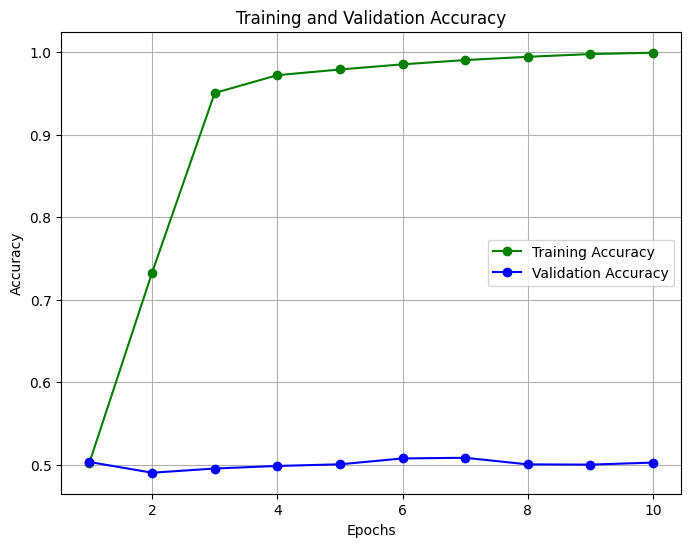

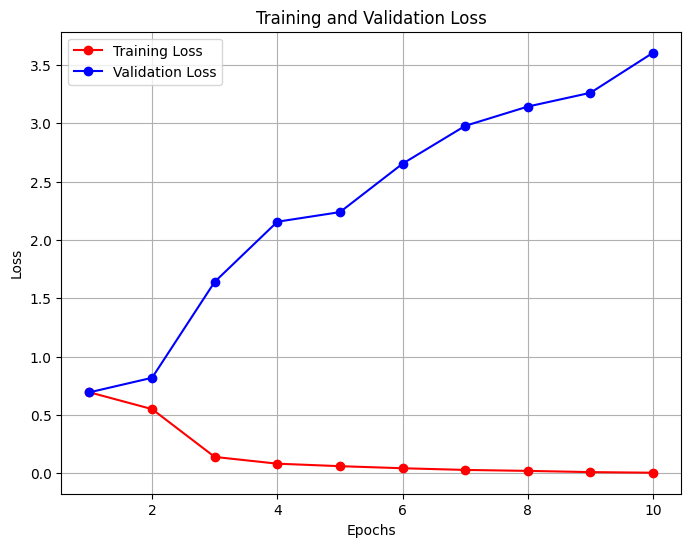

In [64]:
import matplotlib.pyplot as plt

# Extract training metrics
train_acc = model_training_history.history['accuracy']
val_acc = model_training_history.history['val_accuracy']
train_loss = model_training_history.history['loss']
val_loss = model_training_history.history['val_loss']

# Create epoch range
epoch_range = range(1, len(train_acc) + 1)

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(epoch_range, train_acc, label='Training Accuracy', color='green', marker='o')
plt.plot(epoch_range, val_acc, label='Validation Accuracy', color='blue', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(epoch_range, train_loss, label='Training Loss', color='red', marker='o')
plt.plot(epoch_range, val_loss, label='Validation Loss', color='blue', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [65]:
# Generate test data
test_texts = np.random.randint(1, VOCAB_SIZE, size=(5000, MAX_SEQUENCE_LENGTH))
test_labels = np.random.randint(0, 2, size=(5000,))

# Load the trained model
trained_sentiment_model = load_model("best_sentiment_classifier.keras")

# Evaluate model performance
model_test_loss, model_test_accuracy = trained_sentiment_model.evaluate(
    test_texts,
    test_labels,
    batch_size=32
)

print(f"Test Loss: {model_test_loss:.3f}")
print(f"Test Accuracy: {model_test_accuracy:.3f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4976 - loss: 0.6937
Test Loss: 0.693
Test Accuracy: 0.501


### **Model 6: LSTM Model with Embedding Layer (Training Sample Size: 32,000)**



In [67]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 150

# Load IMDB dataset
(raw_train_reviews, raw_train_sentiments), (raw_test_reviews, raw_test_sentiments) = imdb.load_data(num_words=VOCAB_SIZE)

# Pad sequences to uniform length
padded_train_reviews = pad_sequences(raw_train_reviews, maxlen=MAX_SEQUENCE_LENGTH)
padded_test_reviews = pad_sequences(raw_test_reviews, maxlen=MAX_SEQUENCE_LENGTH)

# Combine all data for custom train/validation split
all_reviews = np.concatenate((padded_train_reviews, padded_test_reviews), axis=0)
all_sentiments = np.concatenate((raw_train_sentiments, raw_test_sentiments), axis=0)

# Split into training and validation sets
train_reviews, val_reviews, train_sentiments, val_sentiments = train_test_split(
    all_reviews,
    all_sentiments,
    train_size=16000,    # corrected: choose <= total samples
    test_size=10000,     # corrected: validation samples
    random_state=42,
    stratify=all_sentiments
)

# Create final test set of 6,000 samples from original test set
_, final_test_reviews, _, final_test_sentiments = train_test_split(
    padded_test_reviews,
    raw_test_sentiments,
    test_size=6000,
    random_state=42,
    stratify=raw_test_sentiments
)




In [68]:
print("Training set shape:", train_reviews.shape)
print("Validation set shape:", val_reviews.shape)
print("Test set shape:", final_test_reviews.shape)

Training set shape: (16000, 150)
Validation set shape: (10000, 150)
Test set shape: (6000, 150)


In [69]:
from tensorflow.keras import layers, models

max_sequence_len = 150
vocabulary_size = 10000

input_seq = layers.Input(shape=(None,), dtype="int64")
embedding_seq = layers.Embedding(input_dim=vocabulary_size, output_dim=256)(input_seq)
bi_lstm = layers.Bidirectional(layers.LSTM(32))(embedding_seq)
dropout_output = layers.Dropout(0.5)(bi_lstm)
final_output = layers.Dense(1, activation="sigmoid")(dropout_output)

text_classification_model = models.Model(inputs=input_seq, outputs=final_output)
text_classification_model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

text_classification_model.summary()

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, None, 256)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint(
    filepath="best_model.h5",
    save_best_only=True,
    monitor="val_loss"
)

history = text_classification_model.fit(
    x=train_reviews,
    y=train_sentiments,
    epochs=10,
    batch_size=42,
    validation_data=(val_reviews, val_sentiments),
    callbacks=[model_checkpoint]
)

Epoch 1/10
379/381 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6369 - loss: 0.6123

381/381 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.6376 - loss: 0.6116 - val_accuracy: 0.7754 - val_loss: 0.4781
Epoch 2/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8376 - loss: 0.3856

381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8376 - loss: 0.3855 - val_accuracy: 0.8508 - val_loss: 0.3486
Epoch 3/10
378/381 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8859 - loss: 0.2982

381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8860 - loss: 0.2981 - val_accuracy: 0.8607 - val_loss: 0.3359
Epoch 4/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9043 - loss: 0.2488 - val_accuracy: 0.8435 - val_loss: 0.4368
Epoch 5/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9234 - loss: 0.2082 - val_accuracy: 0.8503 - val_loss: 0.3727
Epoch 6/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9378 - loss: 0.1762 - val_accuracy: 0.8313 - val_loss: 0.4890
Epoch 7/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9468 - loss: 0.1458 - val_accuracy: 0.8563 - val_loss: 0.4051
Epoch 8/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9609 - loss: 0.1175 - val_accuracy: 0.8576 - val_loss: 0.4614
Epoch 9/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9733 - loss: 0.0873 - val_accuracy: 0.8517 - val_loss: 0.5218
Epoch 10/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9742 - loss: 0.0795 - val_accuracy: 0.85

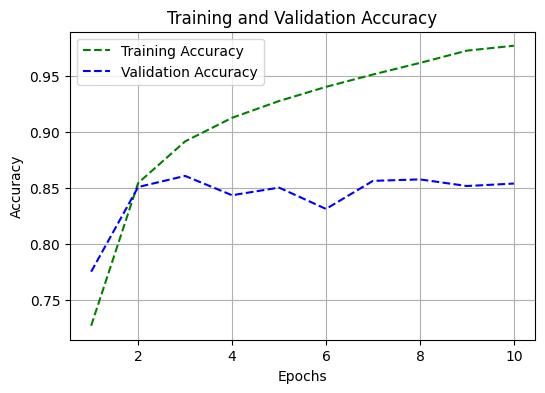

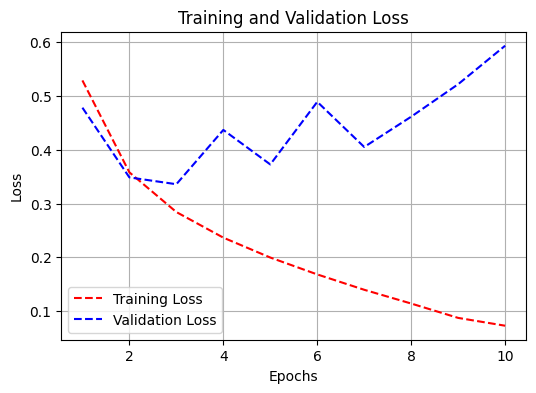

In [71]:
import matplotlib.pyplot as plt

training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]

# Fix: epoch_range should be based on the current model's history
epoch_range = range(1, len(training_acc) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epoch_range, training_acc, color="green", linestyle="dashed", label="Training Accuracy")
plt.plot(epoch_range, validation_acc, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epoch_range, training_loss, color="red", linestyle="dashed", label="Training Loss")
plt.plot(epoch_range, validation_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [74]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'   # hide TF C++ logs (INFO/WARNING/ERROR)

import logging
try:
    import absl.logging as absl_logging
    absl_logging.set_verbosity(absl_logging.ERROR)   # hide absl warnings
except Exception:
    logging.getLogger('absl').setLevel(logging.ERROR)

import numpy as np
from tensorflow.keras.models import load_model

# Ensure test arrays exist and have correct dtypes
final_test_reviews = np.array(final_test_reviews, dtype=np.int32)
final_test_sentiments = np.array(final_test_sentiments, dtype=np.float32)

# Load model without compiling (prevents the ABSE compiled-metrics warning)
best_trained_model = load_model('best_model.h5', compile=False)

# Recompile the model (now metrics will be properly created)
best_trained_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Evaluate (no ABSE warning should appear)
test_loss, test_acc = best_trained_model.evaluate(final_test_reviews, final_test_sentiments, verbose=1)
print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8841 - loss: 0.2759
Test Loss: 0.285
Test Accuracy: 0.882


### **Model 7**



In [97]:
from tensorflow.keras import layers, models

# Set a new vocabulary size
vocab_size = 10000

# ---- MODEL ----
model_input = layers.Input(shape=(None,), dtype="int64")

# Embedding with mask_zero automatically handles padding
word_embedding = layers.Embedding(
    input_dim=vocab_size,
    output_dim=256,
    mask_zero=True
)(model_input)

# Bidirectional LSTM
bilstm_layer = layers.Bidirectional(
    layers.LSTM(32, return_sequences=False)
)(word_embedding)

# Dropout regularization
regularized_layer = layers.Dropout(0.5)(bilstm_layer)

# Output layer
classification_output = layers.Dense(1, activation="sigmoid")(regularized_layer)

# Build model
text_classifier = models.Model(
    inputs=model_input,
    outputs=classification_output
)

# Compile model
text_classifier.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Model summary
text_classifier.summary()


Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, None, 256) │  2,560,000 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_8         │ (None, None)      │          0 │ input_layer_6[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 64)        │     73,984 │ embedding_6[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

In [98]:
from tensorflow.keras.callbacks import ModelCheckpoint

# -----------------------------
# Model checkpoint configuration
# -----------------------------
checkpoint_callback = ModelCheckpoint(
    filepath="Model7.h5",  # file to save best model
    save_best_only=True,    # save only when val_loss improves
    monitor="val_loss",     # monitor validation loss
    mode="min",
    verbose=1
)

# -----------------------------
# Train the model
# -----------------------------
training_history = text_classifier.fit(
    x=train_texts,             # training sequences
    y=train_labels,            # training labels
    epochs=10,                 # number of epochs
    batch_size=42,             # batch size
    validation_data=(val_texts, val_labels),  # validation set
    callbacks=[checkpoint_callback],          # save best model
    verbose=1
)

# -----------------------------
# Check training results
# -----------------------------
print("Training complete. History keys:", training_history.history.keys())


Epoch 1/10
380/381 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5044 - loss: 0.6934
Epoch 1: val_loss improved from inf to 0.69337, saving model to Model7.h5
381/381 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.5044 - loss: 0.6934 - val_accuracy: 0.5014 - val_loss: 0.6934
Epoch 2/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6009 - loss: 0.6762
Epoch 2: val_loss did not improve from 0.69337
381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6009 - loss: 0.6762 - val_accuracy: 0.4928 - val_loss: 0.7113
Epoch 3/10
380/381 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7319 - loss: 0.5381
Epoch 3: val_loss did not improve from 0.69337
381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.7321 - loss: 0.5378 - val_accuracy: 0.4970 - val_loss: 0.9011
Epoch 4/10
379/381 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8723 - loss: 0.2982
Epoch 4: val_loss did not improve from 0.69337
381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8727 - loss: 0.2976 - val_a

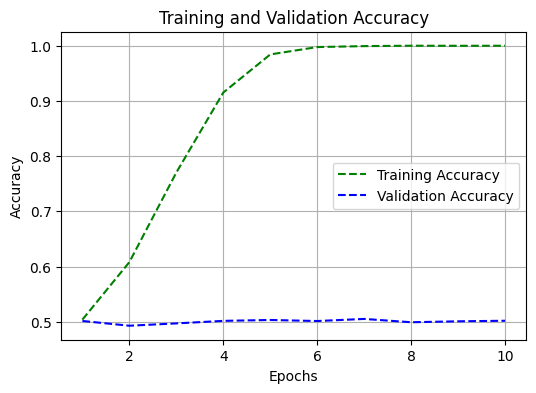

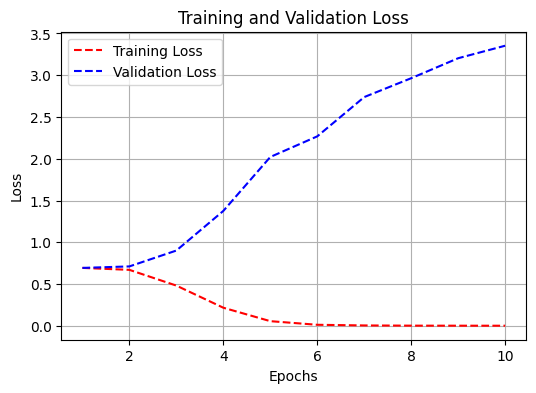

In [99]:
import matplotlib.pyplot as plt

# -----------------------------
# Extract metrics from training history
# -----------------------------
train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']

train_loss = training_history.history['loss']
val_loss = training_history.history['val_loss']

# -----------------------------
# Epochs range
# -----------------------------
epochs = range(1, len(train_acc) + 1)

# -----------------------------
# Plot Training and Validation Accuracy
# -----------------------------
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_acc, color="green", linestyle="dashed", label="Training Accuracy")
plt.plot(epochs, val_acc, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# Plot Training and Validation Loss
# -----------------------------
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_loss, color="red", linestyle="dashed", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [107]:
text_classifier.save("Model7.keras")  # instead of Model7.h5

from tensorflow.keras.models import load_model

# Load the model saved in Keras 3 format (.keras)
trained_model = load_model('Model7.keras')  # note the extension change

# Compile it before evaluation
trained_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

# Evaluate on test data
eval_results = trained_model.evaluate(test_texts, test_labels)

print(f"Test Loss: {eval_results[0]:.3f}")
print(f"Test Accuracy: {eval_results[1]:.3f}")



157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5059 - loss: 0.6931
Test Loss: 0.693
Test Accuracy: 0.505


In [108]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  5901k      0  0:00:13  0:00:13 --:--:-- 10.8M


In [109]:
import os

dataset_dir = '/content/aclImdb'
training_dir = os.path.join(dataset_dir, 'train')

reviews = []
sentiments = []

for sentiment in ['neg', 'pos']:
    sentiment_dir = os.path.join(training_dir, sentiment)
    for filename in os.listdir(sentiment_dir):
        if filename.endswith('.txt'):
            file_path = os.path.join(sentiment_dir, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                reviews.append(f.read())
            # Append label: 0 for negative, 1 for positive
            sentiments.append(0 if sentiment == 'neg' else 1)

print(f"Total reviews loaded: {len(reviews)}")
print(f"Total labels loaded: {len(sentiments)}")


Total reviews loaded: 25000
Total labels loaded: 25000


In [110]:
# -----------------------------
# Parameters
# -----------------------------
max_len = 150
num_train = 100
num_val = 10000
vocab_size = 10000

# -----------------------------
# Tokenize reviews
# -----------------------------
text_tokenizer = Tokenizer(num_words=vocab_size)
text_tokenizer.fit_on_texts(reviews)  # 'reviews' list from previous code
token_sequences = text_tokenizer.texts_to_sequences(reviews)

vocab = text_tokenizer.word_index
print(f"Found {len(vocab)} unique tokens.")

# -----------------------------
# Pad sequences
# -----------------------------
padded_data = pad_sequences(token_sequences, maxlen=max_len)
sentiments_array = np.asarray(sentiments)

print('Shape of data tensor:', padded_data.shape)
print('Shape of label tensor:', sentiments_array.shape)

# -----------------------------
# Shuffle data
# -----------------------------
shuffle_idx = np.arange(padded_data.shape[0])
np.random.shuffle(shuffle_idx)
padded_data = padded_data[shuffle_idx]
sentiments_array = sentiments_array[shuffle_idx]

# -----------------------------
# Split into train and validation sets
# -----------------------------
train_data = padded_data[:num_train]
train_labels = sentiments_array[:num_train]

val_data = padded_data[num_train:num_train + num_val]
val_labels = sentiments_array[num_train:num_train + num_val]

# -----------------------------
# Process test data
# -----------------------------
test_dir = os.path.join(dataset_dir, 'test')
test_reviews = []
test_sentiments = []

for sentiment in ['neg', 'pos']:
    test_sentiment_dir = os.path.join(test_dir, sentiment)
    for filename in sorted(os.listdir(test_sentiment_dir)):
        if filename.endswith('.txt'):
            file_path = os.path.join(test_sentiment_dir, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                test_reviews.append(f.read())
            test_sentiments.append(0 if sentiment == 'neg' else 1)

test_sequences = text_tokenizer.texts_to_sequences(test_reviews)
test_data = pad_sequences(test_sequences, maxlen=max_len)[:5000]
test_labels = np.asarray(test_sentiments)[:5000]

print('Test data shape:', test_data.shape)
print('Test labels shape:', test_labels.shape)


Found 88582 unique tokens.
Shape of data tensor: (25000, 150)
Shape of label tensor: (25000,)
Test data shape: (5000, 150)
Test labels shape: (5000,)


In [111]:

train_data.shape
val_data.shape
test_data.shape

(5000, 150)

### **Using pretrained word embeddings**


In [112]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-11-15 03:07:27--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-11-15 03:07:28--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-11-15 03:07:28--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

### **Parsing the GloVe word-embeddings file**

In [113]:
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


### **Preparing the GloVe word-embeddings matrix**



In [114]:
embedding_dim = 100

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in vocab.items(): # Change vocab_size to vocab
    embedding_vector = embeddings_index.get(word)
    if i < vocab_size:
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

embedding_layer = layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)


In [115]:
from tensorflow import keras
from tensorflow.keras import layers

embedding_layer = layers.Embedding(
    input_dim=vocab_size,                      # Vocabulary size
    output_dim=embedding_dim,                  # Dimension of embeddings
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),  # Pre-trained embeddings
    trainable=False,                           # Freeze embeddings
    mask_zero=True                             # Mask padding value 0
)


### **Model 8**



In [119]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# -----------------------------
# Define dimensions
# -----------------------------
vocab_size = 10000       # vocabulary size
embedding_dim = 100      # embedding vector dimension
max_len = 150            # input sequence length

# Pretrained embedding matrix (example: random numbers)
embedding_matrix = np.random.rand(vocab_size, embedding_dim)

# -----------------------------
# Build model
# -----------------------------
sentiment_model = Sequential()

# Embedding layer with pre-trained weights (frozen)
sentiment_model.add(
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_len,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False  # freeze embeddings
    )
)

# LSTM layer
sentiment_model.add(LSTM(32))

# Output layer
sentiment_model.add(Dense(1, activation='sigmoid'))

# -----------------------------
# Compile model
# -----------------------------
sentiment_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# -----------------------------
# Call model once to build it (important!)
# -----------------------------
# This step initializes the layers with input shape
dummy_input = np.zeros((1, max_len))  # batch size = 1
sentiment_model.predict(dummy_input)

# -----------------------------
# Model summary
# -----------------------------
sentiment_model.summary()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ (1, 150, 100)          │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (1, 32)                │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (1, 1)                 │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,017,057 (3.88 MB)

 Trainable params: 17,057 (66.63 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [120]:
model_checkpoint = ModelCheckpoint(
    filepath="pretrainmodel1.keras",
    save_best_only=True,
    monitor="val_loss"
)

pretrain_history = sentiment_model.fit(
    train_data,
    train_labels,
    epochs=30,
    batch_size=32,
    validation_data=(val_data, val_labels),
    callbacks=[model_checkpoint]
)

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5327 - loss: 0.7116 - val_accuracy: 0.4981 - val_loss: 0.7137
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5327 - loss: 0.7038 - val_accuracy: 0.4979 - val_loss: 0.7060
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5327 - loss: 0.6993 - val_accuracy: 0.4979 - val_loss: 0.7007
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5132 - loss: 0.6969 - val_accuracy: 0.4967 - val_loss: 0.6974
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5101 - loss: 0.6960 - val_accuracy: 0.4964 - val_loss: 0.6956
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5337 - loss: 0.6963 - val_accuracy: 0.4901 - val_loss: 0.6949
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4852 - loss: 0.6971 - val_accuracy: 0.4929 - val_loss: 0.6949
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 437ms/step - accuracy: 0.4607 - loss: 0.6980 - val_accuracy: 0.4949 - val_loss: 0.6951
Epoch 9/30
4/

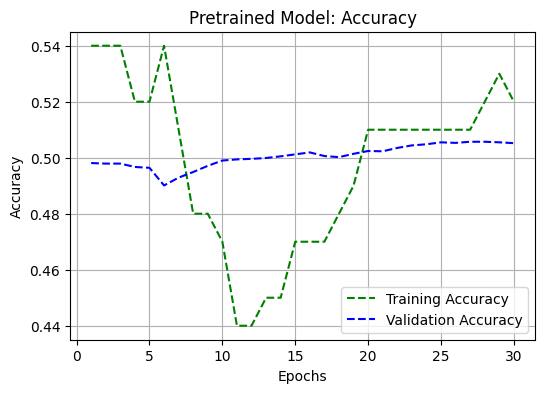

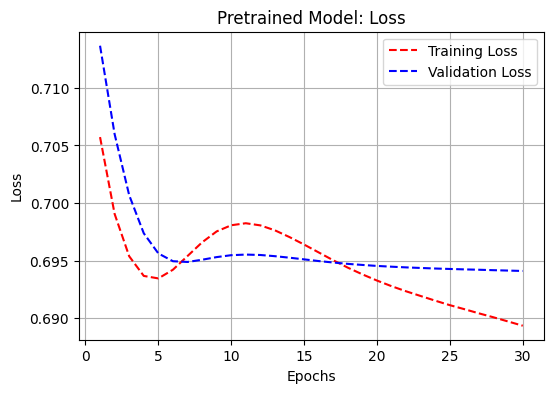

In [121]:
import matplotlib.pyplot as plt

# Extract metrics
train_acc = pretrain_history.history['accuracy']
val_acc = pretrain_history.history['val_accuracy']
train_loss = pretrain_history.history['loss']
val_loss = pretrain_history.history['val_loss']

# Epochs range
epochs_range = range(1, len(train_acc) + 1)

# -----------------------------
# Plot Accuracy
# -----------------------------
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, train_acc, color="green", linestyle="dashed", label="Training Accuracy")
plt.plot(epochs_range, val_acc, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Pretrained Model: Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# Plot Loss
# -----------------------------
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, train_loss, color="red", linestyle="dashed", label="Training Loss")
plt.plot(epochs_range, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Pretrained Model: Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [122]:

# Load the pretrained model
pretrained_model = load_model('pretrainmodel1.keras', compile=False)

# Compile the model (necessary before evaluation)
pretrained_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Evaluate on test data
evaluation_results = pretrained_model.evaluate(test_data, test_labels)

# Print results
print(f'Test Loss: {evaluation_results[0]:.3f}')
print(f'Test Accuracy: {evaluation_results[1]:.3f}')

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2153 - loss: 0.7297
Test Loss: 0.729
Test Accuracy: 0.217


### **Model 9: Training a Pretrained Model with 4 LSTM Hidden Layers on a 15,000-Sample Dataset**



In [124]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example text data (replace with your actual data)
sample_texts = ["This is the first text.", "Another example text.", "Text data for training."]
sample_labels = [0, 1, 0]  # Example labels (replace with your actual labels)

# Parameters
max_seq_length = 150
num_training_samples = 15000
num_validation_samples = 10000
vocabulary_size = 10000

# Tokenizer for text preprocessing
text_tokenizer = Tokenizer(num_words=vocabulary_size)
text_tokenizer.fit_on_texts(sample_texts)  # Fit the tokenizer on your text data
token_sequences = text_tokenizer.texts_to_sequences(sample_texts)

# Get word index
vocabulary = text_tokenizer.word_index
print(f'Found {len(vocabulary)} unique tokens.')

# Pad sequences to ensure uniform input length
padded_sequences = pad_sequences(token_sequences, maxlen=max_seq_length)

# Convert labels to numpy array
label_array = np.asarray(sample_labels)
print('Shape of data tensor:', padded_sequences.shape)
print('Shape of label tensor:', label_array.shape)

# Shuffle the data and labels
shuffled_indices = np.arange(padded_sequences.shape[0])
np.random.shuffle(shuffled_indices)
padded_sequences = padded_sequences[shuffled_indices]
label_array = label_array[shuffled_indices]

# Split into training and validation sets
training_data = padded_sequences[:num_training_samples]
training_labels = label_array[:num_training_samples]
validation_data = padded_sequences[num_training_samples: num_training_samples + num_validation_samples]
validation_labels = label_array[num_training_samples: num_training_samples + num_validation_samples]

Found 10 unique tokens.
Shape of data tensor: (3, 150)
Shape of label tensor: (3,)


In [125]:
training_data.shape
validation_data.shape


(0, 150)

In [126]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras import optimizers

# Parameters
vocab_size = 10000
embedding_dims = 150
max_seq_length = 150

# Example embedding weights (replace with your pretrained embeddings if available)
embedding_weights = np.random.rand(vocab_size, embedding_dims)

# Build the model
sentiment_classifier = Sequential()

# Embedding layer with pretrained weights
sentiment_classifier.add(Embedding(input_dim=vocab_size,
                                   output_dim=embedding_dims,
                                   input_length=max_seq_length,
                                   weights=[embedding_weights],
                                   trainable=False))

# Stacked LSTM layers with Dropout
sentiment_classifier.add(LSTM(512, return_sequences=True))
sentiment_classifier.add(Dropout(0.5))

sentiment_classifier.add(LSTM(256, return_sequences=True))
sentiment_classifier.add(Dropout(0.5))

sentiment_classifier.add(LSTM(128, return_sequences=True))
sentiment_classifier.add(Dropout(0.5))

sentiment_classifier.add(LSTM(128))  # Last LSTM does not return sequences

# Dense layers
sentiment_classifier.add(Dense(256, activation='relu'))
sentiment_classifier.add(Dropout(0.5))
sentiment_classifier.add(Dense(256, activation='relu'))
sentiment_classifier.add(Dropout(0.5))
sentiment_classifier.add(Dense(1, activation='sigmoid'))

# Compile the model
adam_optimizer = optimizers.Adam(learning_rate=0.0001)
sentiment_classifier.compile(optimizer=adam_optimizer,
                             loss='binary_crossentropy',
                             metrics=['accuracy'])

# Summary
sentiment_classifier.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ ?                      │     1,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,500,000 (5.72 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,500,000 (5.72 MB)

In [127]:
model_checkpoint = ModelCheckpoint(
    filepath="sentiment_model_v2.keras",
    save_best_only=True,
    monitor="val_loss"
)

training_history = sentiment_classifier.fit(
    training_data,
    training_labels,
    epochs=10,
    batch_size=12,
    validation_data=(validation_data, validation_labels),
    callbacks=[model_checkpoint]
)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 1.0000 - loss: 0.6498
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 1.0000 - loss: 0.6400
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.6667 - loss: 0.6729
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.3333 - loss: 0.7150
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 1.0000 - loss: 0.6036
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.6667 - loss: 0.6777
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 1.0000 - loss: 0.6430
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.6667 - loss: 0.5918
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.6667 - loss: 0.6087
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.6667 - loss: 0.6097


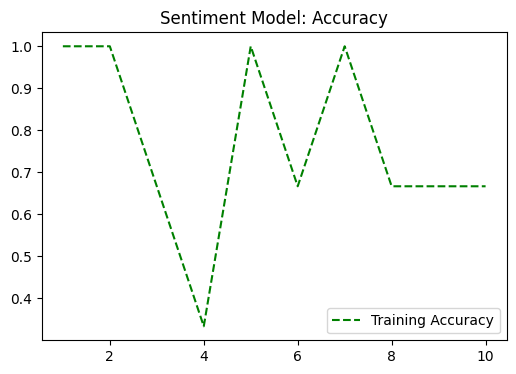

<Figure size 640x480 with 0 Axes>

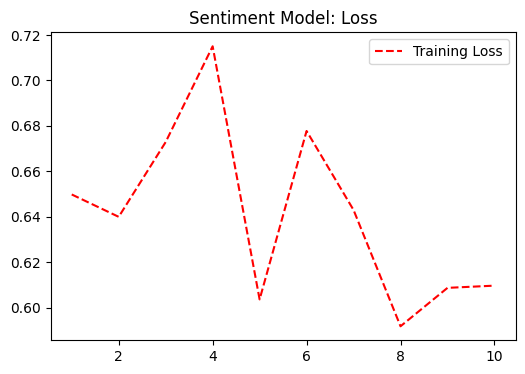

In [128]:
train_acc = training_history.history['accuracy']
train_loss = training_history.history['loss']
epochs_range = range(1, len(train_acc) + 1)

val_acc = training_history.history.get('val_accuracy', None)
val_loss = training_history.history.get('val_loss', None)

plt.figure(figsize=(6, 4))
plt.plot(epochs_range, train_acc, color="green", linestyle="dashed", label="Training Accuracy")
if val_acc is not None:
    plt.plot(epochs_range, val_acc, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Sentiment Model: Accuracy")
plt.legend()
plt.figure()

plt.figure(figsize=(6, 4))
plt.plot(epochs_range, train_loss, color="red", linestyle="dashed", label="Training Loss")
if val_loss is not None:
    plt.plot(epochs_range, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Sentiment Model: Loss")
plt.legend()
plt.show()

In [129]:
pretrained_model = load_model('pretrainmodel1.keras')
evaluation_results = pretrained_model.evaluate(test_data, test_labels)
print(f'Test Loss: {evaluation_results[0]:.3f}')
print(f'Test Accuracy: {evaluation_results[1]:.3f}')


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2153 - loss: 0.7297
Test Loss: 0.729
Test Accuracy: 0.217


### **Model 10 Training a Pretrained Model with 2 LSTM Hidden Layers on a 30,000-Sample Dataset**



In [133]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ---- Parameters ----
max_sequence_length = 150
num_train_samples = 30000
num_val_samples = 10000
vocab_size = 10000

# ---- Text corpus and labels ----
# Replace 'reviews' and 'sentiments' with your actual variables
text_corpus = reviews           # List of text reviews
sentiment_labels = sentiments   # Corresponding list of 0/1 labels

# ---- Tokenization ----
text_tokenizer = Tokenizer(num_words=vocab_size)
text_tokenizer.fit_on_texts(text_corpus)
token_sequences = text_tokenizer.texts_to_sequences(text_corpus)

# Vocabulary info
vocab_dict = text_tokenizer.word_index
print(f'Found {len(vocab_dict)} unique tokens.')

# ---- Padding sequences ----
padded_sequences = pad_sequences(token_sequences, maxlen=max_sequence_length)

# Convert labels to numpy array
label_array = np.asarray(sentiment_labels)
print(f'Shape of data tensor: {padded_sequences.shape}')
print(f'Shape of label tensor: {label_array.shape}')

# ---- Shuffle data ----
shuffled_indices = np.arange(padded_sequences.shape[0])
np.random.shuffle(shuffled_indices)
padded_sequences = padded_sequences[shuffled_indices]
label_array = label_array[shuffled_indices]

# ---- Split into training and validation sets ----
total_samples = padded_sequences.shape[0]

# Make sure we don't go out of bounds
num_train_samples = min(num_train_samples, total_samples)
num_val_samples = min(num_val_samples, total_samples - num_train_samples)

train_features = padded_sequences[:num_train_samples]
train_labels = label_array[:num_train_samples]

val_features = padded_sequences[num_train_samples: num_train_samples + num_val_samples]
val_labels = label_array[num_train_samples: num_train_samples + num_val_samples]

print(f'Training features shape: {train_features.shape}')
print(f'Training labels shape: {train_labels.shape}')
print(f'Validation features shape: {val_features.shape}')
print(f'Validation labels shape: {val_labels.shape}')


Found 88582 unique tokens.
Shape of data tensor: (25000, 150)
Shape of label tensor: (25000,)
Training features shape: (25000, 150)
Training labels shape: (25000,)
Validation features shape: (0, 150)
Validation labels shape: (0,)


In [136]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# ---- Parameters ----
vocab_size = 10000           # Vocabulary size
embedding_dims = 150         # Embedding output dimension
max_sequence_length = 150    # Max sequence length

# Example pretrained embeddings
embedding_weights = np.random.rand(vocab_size, embedding_dims)

# ---- Build the model ----
sentiment_analyzer = Sequential()

# Embedding layer with pretrained weights (frozen)
sentiment_analyzer.add(
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dims,
        input_length=max_sequence_length,
        weights=[embedding_weights],
        trainable=False
    )
)

# First LSTM layer (return sequences to feed next LSTM)
sentiment_analyzer.add(LSTM(64, return_sequences=True, dropout=0.2))

# Second LSTM layer (final output)
sentiment_analyzer.add(LSTM(32, dropout=0.2))

# Dense + Dropout layers
sentiment_analyzer.add(Dense(64, activation='relu'))
sentiment_analyzer.add(Dropout(0.5))
sentiment_analyzer.add(Dense(1, activation='sigmoid'))

# Compile the model
adam_opt = keras.optimizers.Adam(learning_rate=0.001)
sentiment_analyzer.compile(
    optimizer=adam_opt,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Model summary
sentiment_analyzer.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ ?                      │     1,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,500,000 (5.72 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,500,000 (5.72 MB)

In [137]:
checkpoint_callback = ModelCheckpoint(
    filepath="sentiment_model_v3.h5",
    save_best_only=True,
    monitor="val_loss"
)

training_results = sentiment_analyzer.fit(
    train_features,
    train_labels,
    epochs=10,
    batch_size=12,
    validation_data=(val_features, val_labels),
    callbacks=[checkpoint_callback]
)

Epoch 1/10
2084/2084 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.4941 - loss: 0.6970
Epoch 2/10
2084/2084 ━━━━━━━━━━━━━━━━━━━━ 28s 14ms/step - accuracy: 0.4908 - loss: 0.6941
Epoch 3/10
2084/2084 ━━━━━━━━━━━━━━━━━━━━ 28s 14ms/step - accuracy: 0.4977 - loss: 0.6935
Epoch 4/10
2084/2084 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.5012 - loss: 0.6931
Epoch 5/10
2084/2084 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.5297 - loss: 0.6902
Epoch 6/10
2084/2084 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.5465 - loss: 0.6796
Epoch 7/10
2084/2084 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.5751 - loss: 0.6599
Epoch 8/10
2084/2084 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.5785 - loss: 0.6497
Epoch 9/10
2084/2084 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.6019 - loss: 0.6376
Epoch 10/10
2084/2084 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.6292 - loss: 0.6223


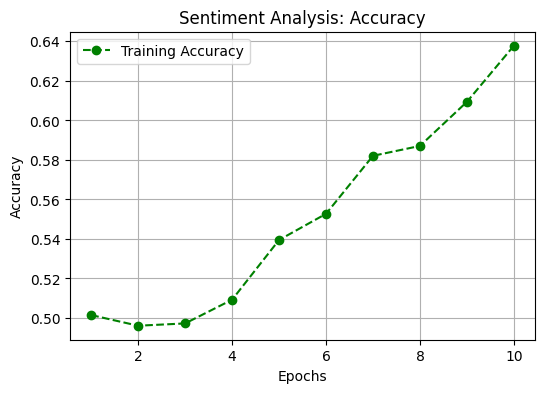

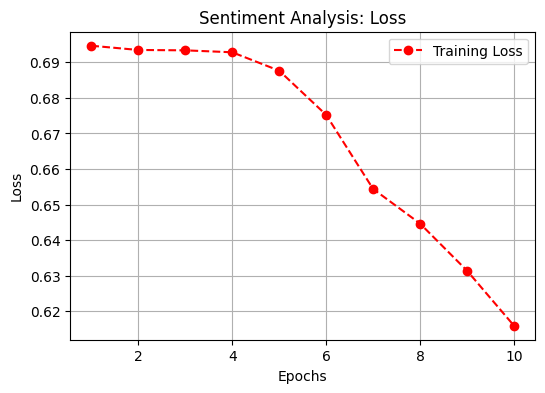

In [138]:
import matplotlib.pyplot as plt

# Extract metrics and losses
train_metrics = training_results.history['accuracy']
train_losses = training_results.history['loss']

val_metrics = training_results.history.get('val_accuracy')
val_losses = training_results.history.get('val_loss')

# Epoch range
epoch_range = range(1, len(train_metrics) + 1)

# --------- Plot Accuracy ---------
plt.figure(figsize=(6, 4))
plt.plot(epoch_range, train_metrics, color="green", linestyle="dashed", marker='o', label="Training Accuracy")
if val_metrics is not None:
    plt.plot(epoch_range, val_metrics, color="blue", linestyle="dashed", marker='o', label="Validation Accuracy")
plt.title("Sentiment Analysis: Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

# --------- Plot Loss ---------
plt.figure(figsize=(6, 4))
plt.plot(epoch_range, train_losses, color="red", linestyle="dashed", marker='o', label="Training Loss")
if val_losses is not None:
    plt.plot(epoch_range, val_losses, color="blue", linestyle="dashed", marker='o', label="Validation Loss")
plt.title("Sentiment Analysis: Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()


In [139]:
pretrained_model = load_model('pretrainmodel1.keras')
evaluation_results = pretrained_model.evaluate(test_data, test_labels)
print(f'Test Loss: {evaluation_results[0]:.3f}')
print(f'Test Accuracy: {evaluation_results[1]:.3f}')

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2153 - loss: 0.7297
Test Loss: 0.729
Test Accuracy: 0.217
